# find enrichment of metabolism genes in CD8 T cells
differential genes from: https://www.sciencedirect.com/science/article/pii/S1097276521002665?via%3Dihub#app2

In [38]:
import pandas as pd
import joblib
from scipy.stats import hypergeom
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
from utils import hypergeometric_test, adjust_p_value_fdr

In [2]:
out_file_path = './'
gene_signature_dir = out_file_path + 'gene_signatures/'
data_dir = './data/cd8_analysis/'
out_dir = out_file_path + 'cd8_atlas/'

# read in data

metabolism signatures

In [3]:
mouse_filename = gene_signature_dir + 'metabolism_terms_mouse.pickle'
mouse_terms = joblib.load(mouse_filename)

In [4]:
for k,v in mouse_terms.items():
    print(f'{k}: {len(v)}')

KEGG_MM_GLYCOLYSIS_GLUCONEOGENESIS: 66
KEGG_MM_CITRATE_CYCLE: 33
KEGG_MM_PENTOSE_PHOSPHATE_PATHWAY: 30
KEGG_MM_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS: 34
KEGG_MM_FRUCTOSE_AND_MANNOSE_METABOLISM: 40
KEGG_MM_GALACTOSE_METABOLISM: 31
KEGG_MM_ASCORBATE_AND_ALDARATE_METABOLISM: 27
KEGG_MM_FATTY_ACID_BIOSYNTHESIS: 6
KEGG_MM_FATTY_ACID_METABOLISM: 48
KEGG_MM_SYNTHESIS_AND_DEGRADATION_OF_KETONE_BODIES: 11
KEGG_MM_STEROID_BIOSYNTHESIS: 17
KEGG_MM_PRIMARY_BILE_ACID_BIOSYNTHESIS: 16
KEGG_MM_STEROID_HORMONE_BIOSYNTHESIS: 58
KEGG_MM_OXIDATIVE_PHOSPHORYLATION: 142
KEGG_MM_PURINE_METABOLISM: 170
KEGG_MM_CAFFEINE_METABOLISM: 9
KEGG_MM_PYRIMIDINE_METABOLISM: 100
KEGG_MM_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM: 35
KEGG_MM_GLYCINE_SERINE_AND_THREONINE_METABOLISM: 39
KEGG_MM_CYSTEINE_AND_METHIONINE_METABOLISM: 39
KEGG_MM_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION: 53
KEGG_MM_VALINE_LEUCINE_AND_ISOLEUCINE_BIOSYNTHESIS: 2
KEGG_MM_LYSINE_BIOSYNTHESIS: 5
KEGG_MM_LYSINE_DEGRADATION: 48
KEGG_MM_ARGININE_AND

CD8 T cell genes

In [5]:
file_name = data_dir + '1-s2.0-S1097276521002665-mmc6.xlsx'
different_genes_xls = pd.ExcelFile(file_name)

In [6]:
xls_sheets = [sheets for sheets in different_genes_xls.sheet_names if sheets[:2] == '5B']

# find enrichment

In [24]:
thresh = 1

In [8]:
cd8_clusters_all = {}
for sheet_name in xls_sheets:
    cd8_clusters_all[sheet_name] = pd.read_excel(file_name, sheet_name=sheet_name)

In [9]:
cd8_clusters_all['5BA_diffexpr-nonnaive-cluster1']

,index,log2FC,x_mean,y_mean,pval,padj
0,Ccl5,1.777520,394.198400,114.934845,0.000000e+00,0.000000e+00
1,Cd7,1.774166,6.941921,1.982906,1.330027e-304,7.421548e-302
2,Rgs1,1.697290,2.236003,0.643902,2.143660e-224,1.196162e-221
3,Tac1,1.250114,0.184353,0.039290,4.808361e-10,2.683065e-07
4,Sept4,1.246985,0.292190,0.084954,1.180546e-56,6.587447e-54
...,...,...,...,...,...,...
496,Hist1h2ao,-2.579769,0.114693,1.013934,1.051254e-21,5.865998e-19
497,Hist1h2ap,-2.598146,0.109936,0.998976,2.403178e-24,1.340973e-21
498,Hist1h2ag,-2.603712,0.093587,0.903714,7.290669e-27,4.068193e-24
499,Birc5,-2.713977,0.011937,0.445003,2.289729e-99,1.277669e-96


# for mouse

In [11]:
M = 9822
hypergeom_res_mouse = {k: {} for k in cd8_clusters_all.keys()}
for cd8_key in cd8_clusters_all.keys():
    df = cd8_clusters_all[cd8_key]
    df = df[df['log2FC'] > thresh]
    df['index'] = df['index'].str.upper()
    df_genes = set(df['index'])
    N = len(df) # length of DE genes
    for k,v in mouse_terms.items():
        n = len(v) # number of met genes
        x = len(df_genes.intersection(v))
        pct_overlap = x/(N+n)
        
        if pct_overlap > 0:
            r = hypergeometric_test(total_genes_expressed=M, n_genes_of_interest=n, 
                                        n_genes_picked=N, n_overlap=x)
            hypergeom_res_mouse[cd8_key][k] = r
        else:
            hypergeom_res_mouse[cd8_key][k] = 1

/tmp/ipykernel_473008/2093253430.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] = df['index'].str.upper()


In [12]:
hypergeom_mouse_df = pd.DataFrame.from_dict(hypergeom_res_mouse)
hypergeom_mouse_df['term'] = hypergeom_mouse_df.index
hypergeom_mouse_df = hypergeom_mouse_df.melt('term')
hypergeom_mouse_df['p'] = hypergeom_mouse_df['value']
hypergeom_mouse_df['padj'] = adjust_p_value_fdr(hypergeom_mouse_df['p'])
hypergeom_mouse_df

,term,variable,value,p,padj
0,KEGG_MM_GLYCOLYSIS_GLUCONEOGENESIS,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.0
1,KEGG_MM_CITRATE_CYCLE,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.0
2,KEGG_MM_PENTOSE_PHOSPHATE_PATHWAY,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.0
3,KEGG_MM_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.0
4,KEGG_MM_FRUCTOSE_AND_MANNOSE_METABOLISM,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.0
...,...,...,...,...,...
1648,KEGG_MM_MTOR_SIGNALING_PATHWAY,5BS_diffexpr-nonnaive-cluster21,1.000000,1.000000,1.0
1649,KEGG_MM_PI3K-AKT_SIGNALING_PATHWAY,5BS_diffexpr-nonnaive-cluster21,0.401578,0.401578,1.0
1650,KEGG_MM_NOD-LIKE_RECEPTOR_SIGNALING_PATHWAY,5BS_diffexpr-nonnaive-cluster21,1.000000,1.000000,1.0
1651,KEGG_MM_INSULIN_SIGNALING_PATHWAY,5BS_diffexpr-nonnaive-cluster21,0.421071,0.421071,1.0


In [13]:
hypergeom_mouse_df[hypergeom_mouse_df['padj'] < 0.05]

,term,variable,value,p,padj
46,KEGG_MM_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN...,5BA_diffexpr-nonnaive-cluster1,0.027159,0.027159,0.043125
277,KEGG_MM_PYRIMIDINE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.027654,0.027654,0.048372
1495,KEGG_MM_PYRIMIDINE_METABOLISM,5BR_diffexpr-nonnaive-cluster20,0.007414,0.007414,0.024029


## remove non-captured genes

### preprocess data to get the genes that passed original filtering

In [23]:
all_counts = pd.read_csv(data_dir + 'GSE164978_cd8t_scRNA_counts.txt')
all_counts

,cell,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,...,Zw10,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3
0,acute_d00|120703408815541,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
1,acute_d00|120703436151718,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,acute_d00|120703436384118,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,acute_d00|120703436568427,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,acute_d00|120703455448371,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31018,transfer_acute_d07|241114589914859,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,2,0,0
31019,transfer_acute_d07|241114607926110,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
31020,transfer_acute_d07|241114608233699,0,0,2,0,0,0,0,1,0,...,0,0,1,0,0,2,1,4,0,0
31021,transfer_acute_d07|241114608515293,0,0,0,0,1,0,0,3,0,...,0,0,0,0,0,0,0,2,0,0


In [153]:
adata = ad.AnnData(all_counts.iloc[:,1:])
adata.obs.index = all_counts['cell']

/tmp/ipykernel_225639/136557891.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(all_counts.iloc[:,1:])
/Genomics/argo/users/azsun/.conda/envs/test/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [154]:
sc.pp.filter_cells(adata, min_genes = 100)
sc.pp.filter_cells(adata, max_counts = 40000)
sc.pp.filter_genes(adata, min_counts = 500)

In [155]:
adata

AnnData object with n_obs × n_vars = 30994 × 10841
    obs: 'n_genes', 'n_counts'
    var: 'n_counts'

In [156]:
adata.var.index = adata.var.index.str.upper()

don't actually filter on b cell cells

In [122]:
b_cell_markers = pd.read_csv(data_dir + 'B_cell_markers_panglao.csv', index_col = 0)
#b_cell_markers['official gene symbol']

In [123]:
sc.tl.score_genes(adata, b_cell_markers['official gene symbol'], score_name = 'score_b_cell')

/Genomics/argo/users/azsun/.conda/envs/test/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


(0.0, 100.0)

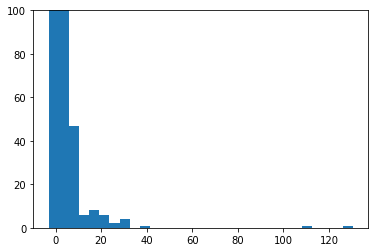

In [86]:
plt.hist(adata.obs['score_b_cell'], bins = 30)
plt.ylim(0,100)

In [89]:
adata.obs['score_b_cell'].sort_values(ascending = False)[:20]

cell
chronic_d35|231340559231204    130.515326
chronic_d07|231340585970092    110.654693
chronic_d35|131234293733660     37.113985
chronic_d35|125728252671782     29.388410
chronic_d35|164761077140269     28.690294
chronic_d35|200967535574427     28.196360
chronic_d35|170745952328437     28.179119
chronic_d35|131217381871006     27.145275
chronic_d35|130675115670452     25.681194
chronic_d35|129978437130996     23.584132
chronic_d35|205449180600030     23.246807
chronic_d35|126681601170149     21.876596
chronic_d35|126294007630181     21.691571
chronic_d35|131293470636396     20.768199
chronic_d07|192325926899099     20.477650
chronic_d35|191576423976292     19.102171
chronic_d35|199962347595693     18.454183
chronic_d35|197256786393523     17.622126
chronic_d35|160447842867115     17.047254
chronic_d07|204358278663006     16.240581
Name: score_b_cell, dtype: float64

remove mitochondrial, ribosomal, and non-coding genes

**don't do this for now** -- otherwise have 7998 genes after, expecting 9822

In [124]:
coding_genes_names = pd.read_csv(data_dir + 'coding_genes_names.csv')
coding_genes_names = coding_genes_names['Gene name']

In [125]:
coding_genes = list(adata.var.index[adata.var.index.isin(coding_genes_names)])
print('removing %s genes' %(len(adata.var_names) - len(coding_genes)))
adata = adata[:, coding_genes].copy()

removing 2726 genes


In [126]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')
adata.var['RP'] = adata.var_names.str.startswith('RP')

In [128]:
adata.var.index[adata.var.index.str.startswith('MT')]

Index(['MT3', 'MTA1', 'MTA2', 'MTA3', 'MTAP', 'MTBP', 'MTCH1', 'MTCH2', 'MTDH',
       'MTERF2', 'MTERF3', 'MTERF4', 'MTF1', 'MTF2', 'MTFMT', 'MTFR1',
       'MTFR1L', 'MTG1', 'MTG2', 'MTHFD1', 'MTHFD1L', 'MTHFD2', 'MTHFD2L',
       'MTHFS', 'MTHFSD', 'MTIF2', 'MTIF3', 'MTM1', 'MTMR1', 'MTMR12',
       'MTMR14', 'MTMR2', 'MTMR3', 'MTMR4', 'MTMR6', 'MTMR9', 'MTO1', 'MTOR',
       'MTPAP', 'MTPN', 'MTR', 'MTRF1', 'MTRF1L', 'MTRR', 'MTURN', 'MTX1',
       'MTX2'],
      dtype='object')

In [129]:
print('removing %s mt genes and %s rp genes' % (sum(adata.var['MT']), sum(adata.var['RP'])))
adata = adata[:,~adata.var['MT']] 
adata = adata[:,~adata.var['RP']]

removing 0 mt genes and 117 rp genes


**filter based on sample-specific counts**

In [158]:
adata.obs['sample'] = [i.split('|')[0] for i in adata.obs.index]

In [159]:
# filter each sample
sample_filter_d = {'acute_d00': 2.85, 'acute_d07': 2.9, 'acute_d40': 2.9, 'chronic_d07': 2.9,
                  'chronic_d35': 2.8, 'chronic_d35_b6': 2.8}
adata_filter_inds = {}
for k,v in sample_filter_d.items():
    adata_c = adata[adata.obs['sample'] == k].copy()
    sc.pp.filter_cells(adata_c, min_counts = 10**v)
    adata_filter_inds[k] = adata_c.obs.index
adata_filter_inds_all = [i for s in adata_filter_inds.values() for i in s]

In [160]:
print(f'remove {len(adata) - len(adata_filter_inds_all)} cells')
print(f'{len(adata_filter_inds_all)} cells remaining')

remove 4287 cells
26707 cells remaining


In [161]:
adata = adata[adata_filter_inds_all].copy()
adata

AnnData object with n_obs × n_vars = 26707 × 10841
    obs: 'n_genes', 'n_counts', 'sample'
    var: 'n_counts'

In [162]:
sc.pp.filter_cells(adata, min_genes = 500)
sc.pp.filter_genes(adata, min_counts = 100)

In [163]:
adata

AnnData object with n_obs × n_vars = 26695 × 10839
    obs: 'n_genes', 'n_counts', 'sample'
    var: 'n_counts'

In [171]:
pd.Series(adata.var.index).to_csv(data_dir + 'genes_captured_all.csv')

### perform hypergeometric test

In [43]:
all_genes = list(pd.read_csv(data_dir + 'genes_captured_all.csv', header = None)[1][1:])
all_genes

['0610007P14RIK',
 '0610009B22RIK',
 '0610009L18RIK',
 '0610009O20RIK',
 '0610010F05RIK',
 '0610010K14RIK',
 '0610012G03RIK',
 '0610030E20RIK',
 '0610037L13RIK',
 '1110002L01RIK',
 '1110004E09RIK',
 '1110004F10RIK',
 '1110008F13RIK',
 '1110008P14RIK',
 '1110012L19RIK',
 '1110032A03RIK',
 '1110034G24RIK',
 '1110037F02RIK',
 '1110038B12RIK',
 '1110038F14RIK',
 '1110059E24RIK',
 '1110059G10RIK',
 '1110065P20RIK',
 '1190002N15RIK',
 '1190007I07RIK',
 '1300002E11RIK',
 '1500004A13RIK',
 '1500009L16RIK',
 '1500011B03RIK',
 '1500011K16RIK',
 '1500015A07RIK',
 '1600002K03RIK',
 '1600012H06RIK',
 '1600014C10RIK',
 '1600020E01RIK',
 '1700001O22RIK',
 '1700007L15RIK',
 '1700008J07RIK',
 '1700012D14RIK',
 '1700017B05RIK',
 '1700019D03RIK',
 '1700020I14RIK',
 '1700020L24RIK',
 '1700021A07RIK',
 '1700021F05RIK',
 '1700025G04RIK',
 '1700028E10RIK',
 '1700034I23RIK',
 '1700037C18RIK',
 '1700037H04RIK',
 '1700047I17RIK2',
 '1700048O20RIK',
 '1700052K11RIK',
 '1700056E22RIK',
 '1700058P15RIK',
 '1700066

In [44]:
def get_overlapping_met_genes(met_dict, all_genes = all_genes, verb = False):
    overlap_res = {}
    n_removed_terms = {}
    for k,v in met_dict.items():
        overlap_res[k] = [i for i in v if i in all_genes]
        if verb:
            print(f'{k}\toriginal: {len(v)} | overlapping: {len(overlap_res[k])} | removed: {len(v) - len(overlap_res[k])}')
        n_removed_terms[k] = len(v) - len(overlap_res[k])
    return overlap_res, n_removed_terms

In [45]:
overlapping_terms, n_removed_terms = get_overlapping_met_genes(mouse_terms, all_genes, verb = True)

KEGG_MM_GLYCOLYSIS_GLUCONEOGENESIS	original: 66 | overlapping: 35 | removed: 31
KEGG_MM_CITRATE_CYCLE	original: 33 | overlapping: 27 | removed: 6
KEGG_MM_PENTOSE_PHOSPHATE_PATHWAY	original: 30 | overlapping: 20 | removed: 10
KEGG_MM_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS	original: 34 | overlapping: 11 | removed: 23
KEGG_MM_FRUCTOSE_AND_MANNOSE_METABOLISM	original: 40 | overlapping: 25 | removed: 15
KEGG_MM_GALACTOSE_METABOLISM	original: 31 | overlapping: 19 | removed: 12
KEGG_MM_ASCORBATE_AND_ALDARATE_METABOLISM	original: 27 | overlapping: 5 | removed: 22
KEGG_MM_FATTY_ACID_BIOSYNTHESIS	original: 6 | overlapping: 4 | removed: 2
KEGG_MM_FATTY_ACID_METABOLISM	original: 48 | overlapping: 31 | removed: 17
KEGG_MM_SYNTHESIS_AND_DEGRADATION_OF_KETONE_BODIES	original: 11 | overlapping: 6 | removed: 5
KEGG_MM_STEROID_BIOSYNTHESIS	original: 17 | overlapping: 12 | removed: 5
KEGG_MM_PRIMARY_BILE_ACID_BIOSYNTHESIS	original: 16 | overlapping: 3 | removed: 13
KEGG_MM_STEROID_HORMONE_BIOSYNTHESIS	

(array([51., 24.,  5.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162., 180.,
        198., 216., 234., 252., 270., 288., 306., 324., 342., 360., 378.,
        396., 414., 432., 450., 468., 486., 504., 522., 540.]),
 <BarContainer object of 30 artists>)

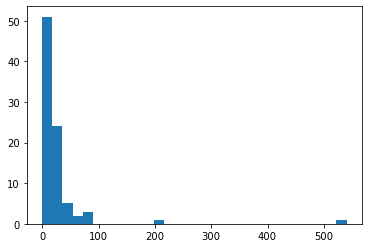

In [23]:
plt.hist(n_removed_terms.values(), bins = 30)

In [46]:
M = 9822
hypergeom_res_mouse_overlap = {k: {} for k in cd8_clusters_all.keys()}
for cd8_key in cd8_clusters_all.keys():
    df = cd8_clusters_all[cd8_key]
    df = df[df['log2FC'] > thresh]
    df['index'] = df['index'].str.upper()
    df_genes = set(df['index'])
    N = len(df) # length of DE genes
    for k,v in overlapping_terms.items():
        n = len(v) # number of met genes
        x = len(df_genes.intersection(v))
        pct_overlap = x/(N+n)
        
        if pct_overlap > 0:
            r = hypergeometric_test(total_genes_expressed=M, n_genes_of_interest=n, 
                                        n_genes_picked=N, n_overlap=x)
            hypergeom_res_mouse_overlap[cd8_key][k] = r
        else:
            hypergeom_res_mouse_overlap[cd8_key][k] = 1

/tmp/ipykernel_473008/1177752755.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] = df['index'].str.upper()


In [47]:
hypergeom_mouse_overlap_df = pd.DataFrame.from_dict(hypergeom_res_mouse_overlap)
hypergeom_mouse_overlap_df['term'] = hypergeom_mouse_overlap_df.index
hypergeom_mouse_overlap_df = hypergeom_mouse_overlap_df.melt('term')
hypergeom_mouse_overlap_df['p'] = hypergeom_mouse_overlap_df['value']
hypergeom_mouse_overlap_df['padj'] = adjust_p_value_fdr(hypergeom_mouse_overlap_df['p'])
hypergeom_mouse_overlap_df

,term,variable,value,p,padj
0,KEGG_MM_GLYCOLYSIS_GLUCONEOGENESIS,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
1,KEGG_MM_CITRATE_CYCLE,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
2,KEGG_MM_PENTOSE_PHOSPHATE_PATHWAY,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
3,KEGG_MM_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
4,KEGG_MM_FRUCTOSE_AND_MANNOSE_METABOLISM,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
...,...,...,...,...,...
1648,KEGG_MM_MTOR_SIGNALING_PATHWAY,5BS_diffexpr-nonnaive-cluster21,1.000000,1.000000,1.000000
1649,KEGG_MM_PI3K-AKT_SIGNALING_PATHWAY,5BS_diffexpr-nonnaive-cluster21,0.111621,0.111621,0.328309
1650,KEGG_MM_NOD-LIKE_RECEPTOR_SIGNALING_PATHWAY,5BS_diffexpr-nonnaive-cluster21,1.000000,1.000000,1.000000
1651,KEGG_MM_INSULIN_SIGNALING_PATHWAY,5BS_diffexpr-nonnaive-cluster21,1.000000,1.000000,1.000000


In [48]:
hypergeom_mouse_overlap_df[hypergeom_mouse_overlap_df['padj'] < 0.05]

,term,variable,value,p,padj
46,KEGG_MM_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN...,5BA_diffexpr-nonnaive-cluster1,0.012762,0.012762,0.034583
261,KEGG_MM_GLYCOLYSIS_GLUCONEOGENESIS,5BD_diffexpr-nonnaive-cluster4,0.021219,0.021219,0.038586
277,KEGG_MM_PYRIMIDINE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.012142,0.012142,0.021261
297,KEGG_MM_GLUTATHIONE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.011578,0.011578,0.021947
829,KEGG_MM_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN...,5BJ_diffexpr-nonnaive-cluster11,0.025384,0.025384,0.030472
1475,KEGG_MM_PI3K-AKT_SIGNALING_PATHWAY,5BQ_diffexpr-nonnaive-cluster18,0.006273,0.006273,0.020657
1495,KEGG_MM_PYRIMIDINE_METABOLISM,5BR_diffexpr-nonnaive-cluster20,0.003512,0.003512,0.011382


# new kegg gene signatures

In [26]:
mouse_filename_2 = gene_signature_dir + 'metabolism_terms_mouse_2.pickle'
mouse_terms_2 = joblib.load(mouse_filename_2)

In [27]:
for k,v in mouse_terms_2.items():
    print(f'{k}: {len(v)}')

KEGG_MM_2-OXOCARBOXYLIC_ACID_METABOLISM: 20
KEGG_MM_AGE-RAGE_SIGNALING_PATHWAY_IN_DIABETIC_COMPLICATIONS: 101
KEGG_MM_AMPK_SIGNALING_PATHWAY: 127
KEGG_MM_ADIPOCYTOKINE_SIGNALING_PATHWAY: 71
KEGG_MM_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM: 39
KEGG_MM_ALDOSTERONE_SYNTHESIS_AND_SECRETION: 102
KEGG_MM_AMINO_SUGAR_AND_NUCLEOTIDE_SUGAR_METABOLISM: 51
KEGG_MM_AMINOACYL-TRNA_BIOSYNTHESIS: 66
KEGG_MM_APELIN_SIGNALING_PATHWAY: 137
KEGG_MM_ARACHIDONIC_ACID_METABOLISM: 86
KEGG_MM_ARGININE_AND_PROLINE_METABOLISM: 54
KEGG_MM_ARGININE_BIOSYNTHESIS: 20
KEGG_MM_ASCORBATE_AND_ALDARATE_METABOLISM: 31
KEGG_MM_BIOSYNTHESIS_OF_AMINO_ACIDS: 79
KEGG_MM_BIOSYNTHESIS_OF_COFACTORS: 152
KEGG_MM_BIOSYNTHESIS_OF_NUCLEOTIDE_SUGARS: 38
KEGG_MM_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS: 34
KEGG_MM_BIOTIN_METABOLISM: 3
KEGG_MM_BUTANOATE_METABOLISM: 27
KEGG_MM_C-TYPE_LECTIN_RECEPTOR_SIGNALING_PATHWAY: 112
KEGG_MM_CAFFEINE_METABOLISM: 6
KEGG_MM_CARBON_METABOLISM: 121
KEGG_MM_CENTRAL_CARBON_METABOLISM_IN_CANCER: 69
KEGG_

In [28]:
M = 9822
hypergeom_res_mouse_2 = {k: {} for k in cd8_clusters_all.keys()}
for cd8_key in cd8_clusters_all.keys():
    df = cd8_clusters_all[cd8_key]
    df = df[df['log2FC'] > thresh]
    df['index'] = df['index'].str.upper()
    df_genes = set(df['index'])
    N = len(df) # length of DE genes
    for k,v in mouse_terms_2.items():
        n = len(v) # number of met genes
        x = len(df_genes.intersection(v))
        pct_overlap = x/(N+n)
        
        if pct_overlap > 0:
            r = hypergeometric_test(total_genes_expressed=M, n_genes_of_interest=n, 
                                        n_genes_picked=N, n_overlap=x)
            hypergeom_res_mouse_2[cd8_key][k] = r
        else:
            hypergeom_res_mouse_2[cd8_key][k] = 1

/tmp/ipykernel_473008/2664119833.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] = df['index'].str.upper()


In [29]:
hypergeom_mouse_2_df = pd.DataFrame.from_dict(hypergeom_res_mouse_2)
hypergeom_mouse_2_df['term'] = hypergeom_mouse_2_df.index
hypergeom_mouse_2_df = hypergeom_mouse_2_df.melt('term')
hypergeom_mouse_2_df['p'] = hypergeom_mouse_2_df['value']
hypergeom_mouse_2_df['padj'] = adjust_p_value_fdr(hypergeom_mouse_2_df['p'])
hypergeom_mouse_2_df

,term,variable,value,p,padj
0,KEGG_MM_2-OXOCARBOXYLIC_ACID_METABOLISM,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
1,KEGG_MM_AGE-RAGE_SIGNALING_PATHWAY_IN_DIABETIC...,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
2,KEGG_MM_AMPK_SIGNALING_PATHWAY,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
3,KEGG_MM_ADIPOCYTOKINE_SIGNALING_PATHWAY,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
4,KEGG_MM_ALANINE_ASPARTATE_AND_GLUTAMATE_METABO...,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
...,...,...,...,...,...
2446,KEGG_MM_ALPHA-LINOLENIC_ACID_METABOLISM,5BS_diffexpr-nonnaive-cluster21,1.000000,1.000000,1.000000
2447,KEGG_MM_BETA-ALANINE_METABOLISM,5BS_diffexpr-nonnaive-cluster21,1.000000,1.000000,1.000000
2448,KEGG_MM_CAMP_SIGNALING_PATHWAY,5BS_diffexpr-nonnaive-cluster21,1.000000,1.000000,1.000000
2449,KEGG_MM_CGMP-PKG_SIGNALING_PATHWAY,5BS_diffexpr-nonnaive-cluster21,0.491640,0.491640,1.000000


In [30]:
hypergeom_mouse_2_df[hypergeom_mouse_2_df['padj'] < 0.05]

,term,variable,value,p,padj
46,KEGG_MM_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN...,5BA_diffexpr-nonnaive-cluster1,0.025370,0.025370,0.039657
462,KEGG_MM_NUCLEOTIDE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.014051,0.014051,0.020294
482,KEGG_MM_PYRIMIDINE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.002539,0.002539,0.004018
2121,KEGG_MM_IL-17_SIGNALING_PATHWAY,5BQ_diffexpr-nonnaive-cluster18,0.020306,0.020306,0.042942
2134,KEGG_MM_NF-KAPPA_B_SIGNALING_PATHWAY,5BQ_diffexpr-nonnaive-cluster18,0.001128,0.001128,0.002317
2174,KEGG_MM_TNF_SIGNALING_PATHWAY,5BQ_diffexpr-nonnaive-cluster18,0.008670,0.008670,0.028446
2268,KEGG_MM_NUCLEOTIDE_METABOLISM,5BR_diffexpr-nonnaive-cluster20,0.004002,0.004002,0.014554
2288,KEGG_MM_PYRIMIDINE_METABOLISM,5BR_diffexpr-nonnaive-cluster20,0.000897,0.000897,0.003251


## remove non-captured genes

In [31]:
all_genes = list(pd.read_csv(data_dir + 'genes_captured_all.csv', header = None)[1][1:])
all_genes

['0610007P14RIK',
 '0610009B22RIK',
 '0610009L18RIK',
 '0610009O20RIK',
 '0610010F05RIK',
 '0610010K14RIK',
 '0610012G03RIK',
 '0610030E20RIK',
 '0610037L13RIK',
 '1110002L01RIK',
 '1110004E09RIK',
 '1110004F10RIK',
 '1110008F13RIK',
 '1110008P14RIK',
 '1110012L19RIK',
 '1110032A03RIK',
 '1110034G24RIK',
 '1110037F02RIK',
 '1110038B12RIK',
 '1110038F14RIK',
 '1110059E24RIK',
 '1110059G10RIK',
 '1110065P20RIK',
 '1190002N15RIK',
 '1190007I07RIK',
 '1300002E11RIK',
 '1500004A13RIK',
 '1500009L16RIK',
 '1500011B03RIK',
 '1500011K16RIK',
 '1500015A07RIK',
 '1600002K03RIK',
 '1600012H06RIK',
 '1600014C10RIK',
 '1600020E01RIK',
 '1700001O22RIK',
 '1700007L15RIK',
 '1700008J07RIK',
 '1700012D14RIK',
 '1700017B05RIK',
 '1700019D03RIK',
 '1700020I14RIK',
 '1700020L24RIK',
 '1700021A07RIK',
 '1700021F05RIK',
 '1700025G04RIK',
 '1700028E10RIK',
 '1700034I23RIK',
 '1700037C18RIK',
 '1700037H04RIK',
 '1700047I17RIK2',
 '1700048O20RIK',
 '1700052K11RIK',
 '1700056E22RIK',
 '1700058P15RIK',
 '1700066

In [32]:
overlapping_terms_2, n_removed_terms_2 = get_overlapping_met_genes(mouse_terms_2, all_genes, verb = True)

KEGG_MM_2-OXOCARBOXYLIC_ACID_METABOLISM	original: 20 | overlapping: 14 | removed: 6
KEGG_MM_AGE-RAGE_SIGNALING_PATHWAY_IN_DIABETIC_COMPLICATIONS	original: 101 | overlapping: 51 | removed: 50
KEGG_MM_AMPK_SIGNALING_PATHWAY	original: 127 | overlapping: 74 | removed: 53
KEGG_MM_ADIPOCYTOKINE_SIGNALING_PATHWAY	original: 71 | overlapping: 41 | removed: 30
KEGG_MM_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM	original: 39 | overlapping: 18 | removed: 21
KEGG_MM_ALDOSTERONE_SYNTHESIS_AND_SECRETION	original: 102 | overlapping: 43 | removed: 59
KEGG_MM_AMINO_SUGAR_AND_NUCLEOTIDE_SUGAR_METABOLISM	original: 51 | overlapping: 39 | removed: 12
KEGG_MM_AMINOACYL-TRNA_BIOSYNTHESIS	original: 66 | overlapping: 41 | removed: 25
KEGG_MM_APELIN_SIGNALING_PATHWAY	original: 137 | overlapping: 71 | removed: 66
KEGG_MM_ARACHIDONIC_ACID_METABOLISM	original: 86 | overlapping: 8 | removed: 78
KEGG_MM_ARGININE_AND_PROLINE_METABOLISM	original: 54 | overlapping: 22 | removed: 32
KEGG_MM_ARGININE_BIOSYNTHESIS	original:

KEGG_MM_CAMP_SIGNALING_PATHWAY	original: 220 | overlapping: 80 | removed: 140
KEGG_MM_CGMP-PKG_SIGNALING_PATHWAY	original: 173 | overlapping: 73 | removed: 100
KEGG_MM_MTOR_SIGNALING_PATHWAY	original: 157 | overlapping: 96 | removed: 61


(array([70., 32., 12.,  9.,  0.,  3.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  0.        ,  25.53333333,  51.06666667,  76.6       ,
        102.13333333, 127.66666667, 153.2       , 178.73333333,
        204.26666667, 229.8       , 255.33333333, 280.86666667,
        306.4       , 331.93333333, 357.46666667, 383.        ,
        408.53333333, 434.06666667, 459.6       , 485.13333333,
        510.66666667, 536.2       , 561.73333333, 587.26666667,
        612.8       , 638.33333333, 663.86666667, 689.4       ,
        714.93333333, 740.46666667, 766.        ]),
 <BarContainer object of 30 artists>)

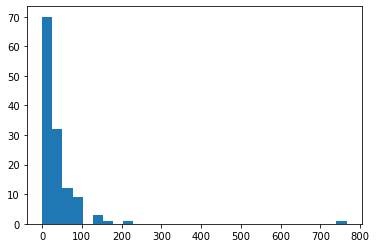

In [34]:
plt.hist(n_removed_terms_2.values(), bins = 30)

In [35]:
M = 9822
hypergeom_res_mouse_overlap_2 = {k: {} for k in cd8_clusters_all.keys()}
for cd8_key in cd8_clusters_all.keys():
    df = cd8_clusters_all[cd8_key]
    df = df[df['log2FC'] > thresh]
    df['index'] = df['index'].str.upper()
    df_genes = set(df['index'])
    N = len(df) # length of DE genes
    for k,v in overlapping_terms_2.items():
        n = len(v) # number of met genes
        x = len(df_genes.intersection(v))
        pct_overlap = x/(N+n)
        
        if pct_overlap > 0:
            r = hypergeometric_test(total_genes_expressed=M, n_genes_of_interest=n, 
                                        n_genes_picked=N, n_overlap=x)
            hypergeom_res_mouse_overlap_2[cd8_key][k] = r
        else:
            hypergeom_res_mouse_overlap_2[cd8_key][k] = 1

/tmp/ipykernel_473008/1807362317.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] = df['index'].str.upper()


In [36]:
hypergeom_mouse_overlap_2_df = pd.DataFrame.from_dict(hypergeom_res_mouse_overlap_2)
hypergeom_mouse_overlap_2_df['term'] = hypergeom_mouse_overlap_2_df.index
hypergeom_mouse_overlap_2_df = hypergeom_mouse_overlap_2_df.melt('term')
hypergeom_mouse_overlap_2_df['p'] = hypergeom_mouse_overlap_2_df['value']
hypergeom_mouse_overlap_2_df['padj'] = adjust_p_value_fdr(hypergeom_mouse_overlap_2_df['p'])
hypergeom_mouse_overlap_2_df

,term,variable,value,p,padj
0,KEGG_MM_2-OXOCARBOXYLIC_ACID_METABOLISM,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
1,KEGG_MM_AGE-RAGE_SIGNALING_PATHWAY_IN_DIABETIC...,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
2,KEGG_MM_AMPK_SIGNALING_PATHWAY,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
3,KEGG_MM_ADIPOCYTOKINE_SIGNALING_PATHWAY,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
4,KEGG_MM_ALANINE_ASPARTATE_AND_GLUTAMATE_METABO...,5BA_diffexpr-nonnaive-cluster1,1.000000,1.000000,1.000000
...,...,...,...,...,...
2446,KEGG_MM_ALPHA-LINOLENIC_ACID_METABOLISM,5BS_diffexpr-nonnaive-cluster21,1.000000,1.000000,1.000000
2447,KEGG_MM_BETA-ALANINE_METABOLISM,5BS_diffexpr-nonnaive-cluster21,1.000000,1.000000,1.000000
2448,KEGG_MM_CAMP_SIGNALING_PATHWAY,5BS_diffexpr-nonnaive-cluster21,1.000000,1.000000,1.000000
2449,KEGG_MM_CGMP-PKG_SIGNALING_PATHWAY,5BS_diffexpr-nonnaive-cluster21,0.247248,0.247248,0.725754


In [37]:
hypergeom_mouse_overlap_2_df[hypergeom_mouse_overlap_2_df['padj'] < 0.05]

,term,variable,value,p,padj
46,KEGG_MM_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN...,5BA_diffexpr-nonnaive-cluster1,0.012762,0.012762,0.023017
350,KEGG_MM_PROLACTIN_SIGNALING_PATHWAY,5BC_diffexpr-nonnaive-cluster3,0.019700,0.019700,0.028337
426,KEGG_MM_GLUTATHIONE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.018129,0.018129,0.027110
430,KEGG_MM_GLYCOLYSIS_GLUCONEOGENESIS,5BD_diffexpr-nonnaive-cluster4,0.024580,0.024580,0.039120
462,KEGG_MM_NUCLEOTIDE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.002964,0.002964,0.004343
482,KEGG_MM_PYRIMIDINE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.000611,0.000611,0.001097
700,KEGG_MM_HIPPO_SIGNALING_PATHWAY,5BF_diffexpr-nonnaive-cluster6,0.016707,0.016707,0.016900
809,KEGG_MM_FOXO_SIGNALING_PATHWAY,5BG_diffexpr-nonnaive-cluster8,0.021590,0.021590,0.025380
869,KEGG_MM_PYRIMIDINE_METABOLISM,5BG_diffexpr-nonnaive-cluster8,0.032561,0.032561,0.038722
1196,KEGG_MM_FOXO_SIGNALING_PATHWAY,5BJ_diffexpr-nonnaive-cluster11,0.039388,0.039388,0.049130


# view all results

In [234]:
hypergeom_mouse_df.to_csv(out_dir + 'hypergeom_results_cd8_1.csv')
hypergeom_mouse_overlap_df.to_csv(out_dir + 'hypergeom_results_cd8_overlap_1.csv')
hypergeom_mouse_2_df.to_csv(out_dir + 'hypergeom_results_cd8_2.csv')
hypergeom_mouse_overlap_2_df.to_csv(out_dir + 'hypergeom_results_cd8_overlap_2.csv')

In [229]:
hypergeom_mouse_df[hypergeom_mouse_df['padj'] < 0.05]

,term,variable,value,p,padj
46,KEGG_MM_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN...,5BA_diffexpr-nonnaive-cluster1,0.027159,0.027159,0.043125
277,KEGG_MM_PYRIMIDINE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.027654,0.027654,0.048372
1495,KEGG_MM_PYRIMIDINE_METABOLISM,5BR_diffexpr-nonnaive-cluster20,0.007414,0.007414,0.024029


In [49]:
hypergeom_mouse_overlap_df[hypergeom_mouse_overlap_df['padj'] < 0.05]

,term,variable,value,p,padj
46,KEGG_MM_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN...,5BA_diffexpr-nonnaive-cluster1,0.012762,0.012762,0.034583
261,KEGG_MM_GLYCOLYSIS_GLUCONEOGENESIS,5BD_diffexpr-nonnaive-cluster4,0.021219,0.021219,0.038586
277,KEGG_MM_PYRIMIDINE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.012142,0.012142,0.021261
297,KEGG_MM_GLUTATHIONE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.011578,0.011578,0.021947
829,KEGG_MM_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN...,5BJ_diffexpr-nonnaive-cluster11,0.025384,0.025384,0.030472
1475,KEGG_MM_PI3K-AKT_SIGNALING_PATHWAY,5BQ_diffexpr-nonnaive-cluster18,0.006273,0.006273,0.020657
1495,KEGG_MM_PYRIMIDINE_METABOLISM,5BR_diffexpr-nonnaive-cluster20,0.003512,0.003512,0.011382


In [230]:
hypergeom_mouse_2_df[hypergeom_mouse_2_df['padj'] < 0.05]

,term,variable,value,p,padj
46,KEGG_MM_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN...,5BA_diffexpr-nonnaive-cluster1,0.025370,0.025370,0.039657
462,KEGG_MM_NUCLEOTIDE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.014051,0.014051,0.020294
482,KEGG_MM_PYRIMIDINE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.002539,0.002539,0.004018
2121,KEGG_MM_IL-17_SIGNALING_PATHWAY,5BQ_diffexpr-nonnaive-cluster18,0.020306,0.020306,0.042942
2134,KEGG_MM_NF-KAPPA_B_SIGNALING_PATHWAY,5BQ_diffexpr-nonnaive-cluster18,0.001128,0.001128,0.002317
2174,KEGG_MM_TNF_SIGNALING_PATHWAY,5BQ_diffexpr-nonnaive-cluster18,0.008670,0.008670,0.028446
2268,KEGG_MM_NUCLEOTIDE_METABOLISM,5BR_diffexpr-nonnaive-cluster20,0.004002,0.004002,0.014554
2288,KEGG_MM_PYRIMIDINE_METABOLISM,5BR_diffexpr-nonnaive-cluster20,0.000897,0.000897,0.003251


In [232]:
hypergeom_mouse_overlap_2_df[hypergeom_mouse_overlap_2_df['padj'] < 0.05]

,term,variable,value,p,padj
46,KEGG_MM_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN...,5BA_diffexpr-nonnaive-cluster1,0.012762,0.012762,0.023017
350,KEGG_MM_PROLACTIN_SIGNALING_PATHWAY,5BC_diffexpr-nonnaive-cluster3,0.019700,0.019700,0.028337
426,KEGG_MM_GLUTATHIONE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.018129,0.018129,0.027110
430,KEGG_MM_GLYCOLYSIS_GLUCONEOGENESIS,5BD_diffexpr-nonnaive-cluster4,0.024580,0.024580,0.039120
462,KEGG_MM_NUCLEOTIDE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.002964,0.002964,0.004343
482,KEGG_MM_PYRIMIDINE_METABOLISM,5BD_diffexpr-nonnaive-cluster4,0.000611,0.000611,0.001097
700,KEGG_MM_HIPPO_SIGNALING_PATHWAY,5BF_diffexpr-nonnaive-cluster6,0.016707,0.016707,0.016900
809,KEGG_MM_FOXO_SIGNALING_PATHWAY,5BG_diffexpr-nonnaive-cluster8,0.021590,0.021590,0.025380
869,KEGG_MM_PYRIMIDINE_METABOLISM,5BG_diffexpr-nonnaive-cluster8,0.032561,0.032561,0.038722
1196,KEGG_MM_FOXO_SIGNALING_PATHWAY,5BJ_diffexpr-nonnaive-cluster11,0.039388,0.039388,0.049130
